In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define dataset loader with optional train/test size parameters
def load_dataset(dataset_name="MNIST", batch_size=32, train_size=100, test_size=20):
    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        full_train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        full_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Currently supported: 'MNIST', 'CIFAR10'.")

    # Subset the datasets if sizes are specified
    if train_size is not None and train_size < len(full_train_dataset):
        train_dataset = torch.utils.data.Subset(full_train_dataset, range(train_size))
    else:
        train_dataset = full_train_dataset

    if test_size is not None and test_size < len(full_test_dataset):
        test_dataset = torch.utils.data.Subset(full_test_dataset, range(test_size))
    else:
        test_dataset = full_test_dataset

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

### MNIST FULL DATASET - FCN - RUN 1

2025-02-02 18:34:24,458 - INFO - Loading MNIST dataset with batch size 16, train_size=None, test_size=None
2025-02-02 18:34:24,475 - INFO - Dataset successfully loaded.
2025-02-02 18:34:24,477 - INFO - Starting training for 200 epochs
2025-02-02 18:34:27,371 - INFO - Epoch [1/200], Loss: 0.536426
2025-02-02 18:34:27,373 - INFO - Computed alignment: 0.096508
2025-02-02 18:34:27,409 - INFO - Epoch [1/200], Rank: 15
2025-02-02 18:34:27,410 - INFO - Epoch [1/200], Gradient Noise Scale: 14.764095
2025-02-02 18:34:30,232 - INFO - Epoch [2/200], Loss: 0.250528
2025-02-02 18:34:30,234 - INFO - Computed alignment: 0.130156
2025-02-02 18:34:30,267 - INFO - Epoch [2/200], Rank: 15
2025-02-02 18:34:30,268 - INFO - Epoch [2/200], Gradient Noise Scale: 15.267179
2025-02-02 18:34:33,041 - INFO - Epoch [3/200], Loss: 0.187605
2025-02-02 18:34:33,043 - INFO - Computed alignment: 0.106248
2025-02-02 18:34:33,079 - INFO - Epoch [3/200], Rank: 15
2025-02-02 18:34:33,080 - INFO - Epoch [3/200], Gradient No

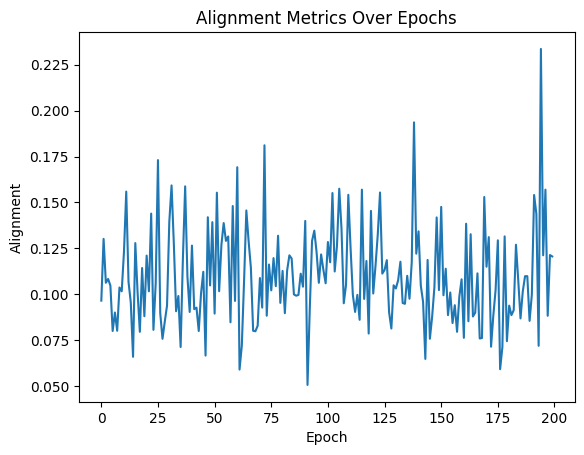

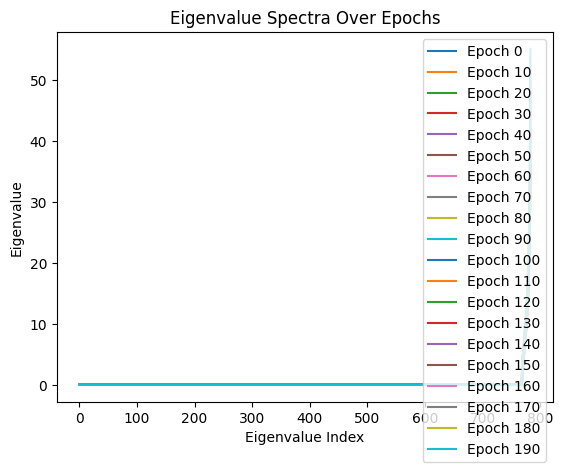

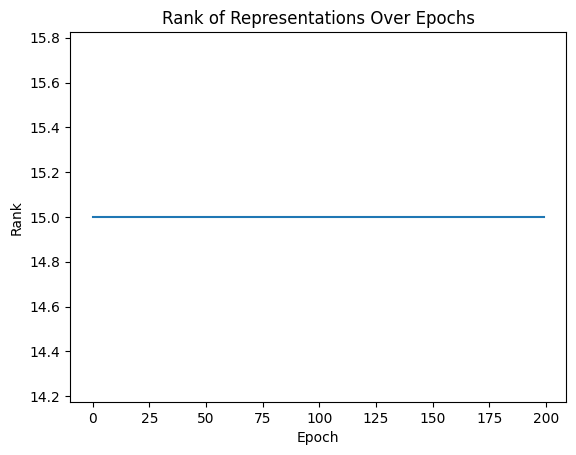

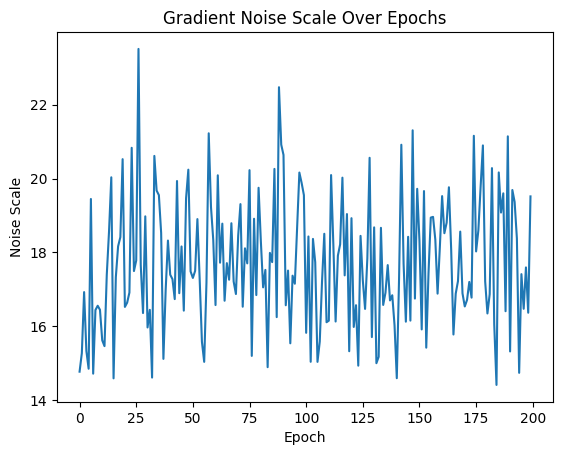

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import logging
from scipy.stats import linregress

# Set up logging
logging.basicConfig(
    filename="training.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="w"
)
logger = logging.getLogger()

# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define dataset loader with optional train/test size limits
def load_dataset(dataset_name="MNIST", batch_size=32, train_size=None, test_size=None):
    logger.info(f"Loading {dataset_name} dataset with batch size {batch_size}, train_size={train_size}, test_size={test_size}")

    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        full_train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    else:
        logger.error("Unsupported dataset. Only 'MNIST' is supported.")
        raise ValueError("Unsupported dataset. Currently only 'MNIST' is supported.")

    train_dataset = full_train_dataset if train_size is None else Subset(full_train_dataset, range(train_size))
    test_dataset = full_test_dataset if test_size is None else Subset(full_test_dataset, range(test_size))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    logger.info("Dataset successfully loaded.")
    return train_loader, test_loader

# Define a simple fully connected neural network
class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

# Function to compute alignment metrics
def compute_alignment(matrix1, matrix2):
    norm1 = torch.norm(matrix1, p='fro')
    norm2 = torch.norm(matrix2, p='fro')
    alignment = torch.trace(matrix1 @ matrix2.T) / (norm1 * norm2)
    logger.info(f"Computed alignment: {alignment.item():.6f}")
    return alignment.item()

# Function to compute power-law exponents
def compute_power_law_exponent(eigenvalues):
    indices = np.arange(1, len(eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))
    logger.info(f"Computed power-law exponent: {slope:.6f}")
    return slope

# Training loop with logging
def train_and_log_metrics(model, dataloader, optimizer, criterion, num_epochs=10):
    logger.info(f"Starting training for {num_epochs} epochs")

    alignments = []
    eigenvalue_spectra = []
    rank_history = []
    gradient_noise_scales = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for X, y in dataloader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

        # Compute metrics
        with torch.no_grad():
            weights = model.model[0].weight
            gradients = model.model[0].weight.grad

            covariance_h = torch.cov(X.view(X.size(0), -1).T)
            covariance_g = torch.cov(gradients.T)

            alignment = compute_alignment(covariance_h, covariance_g)
            alignments.append(alignment)

            eigenvalues_h = torch.linalg.eigvalsh(covariance_h).cpu().numpy()
            eigenvalue_spectra.append(eigenvalues_h)

            rank = torch.linalg.matrix_rank(covariance_h).item()
            rank_history.append(rank)
            logger.info(f"Epoch [{epoch+1}/{num_epochs}], Rank: {rank}")

            grad_norm = torch.norm(gradients)
            noise_scale = grad_norm / (torch.norm(gradients, dim=1).mean())
            gradient_noise_scales.append(noise_scale.item())
            logger.info(f"Epoch [{epoch+1}/{num_epochs}], Gradient Noise Scale: {noise_scale.item():.6f}")

    logger.info("Training completed successfully.")
    return alignments, eigenvalue_spectra, rank_history, gradient_noise_scales

# Visualization functions
def plot_alignment(alignments):
    plt.plot(alignments)
    plt.title("Alignment Metrics Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Alignment")
    plt.show()

def plot_eigenvalues(eigenvalue_spectra):
    for epoch, eigvals in enumerate(eigenvalue_spectra):
        if epoch % 10 == 0:
            plt.plot(eigvals, label=f"Epoch {epoch}")
    plt.title("Eigenvalue Spectra Over Epochs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.show()

def plot_rank_history(rank_history):
    plt.plot(rank_history)
    plt.title("Rank of Representations Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Rank")
    plt.show()

def plot_gradient_noise_scales(gradient_noise_scales):
    plt.plot(gradient_noise_scales)
    plt.title("Gradient Noise Scale Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Noise Scale")
    plt.show()

# Main script
if __name__ == "__main__":
    try:
        # Parameters
        input_dim = 28 * 28  # For MNIST
        hidden_dim = 128
        output_dim = 10
        batch_size = 16
        learning_rate = 0.01
        num_epochs = 200

        # Load dataset and model
        train_loader, test_loader = load_dataset("MNIST", batch_size=batch_size)

        model = FullyConnectedNet(input_dim, hidden_dim, output_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Train and log metrics
        alignments, eigenvalue_spectra, rank_history, gradient_noise_scales = train_and_log_metrics(
            model, train_loader, optimizer, criterion, num_epochs
        )

        # Plot results
        plot_alignment(alignments)
        plot_eigenvalues(eigenvalue_spectra)
        plot_rank_history(rank_history)
        plot_gradient_noise_scales(gradient_noise_scales)

    except Exception as e:
        logger.critical(f"Fatal error in training: {str(e)}", exc_info=True)


### MNIST 100:20 (TRAIN:TEST) - FCN - RUN 1

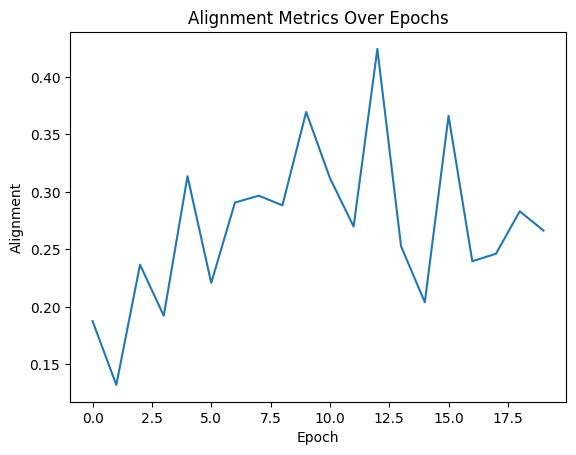

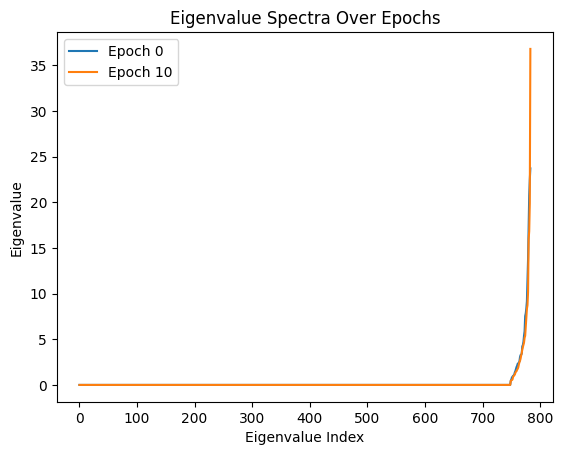

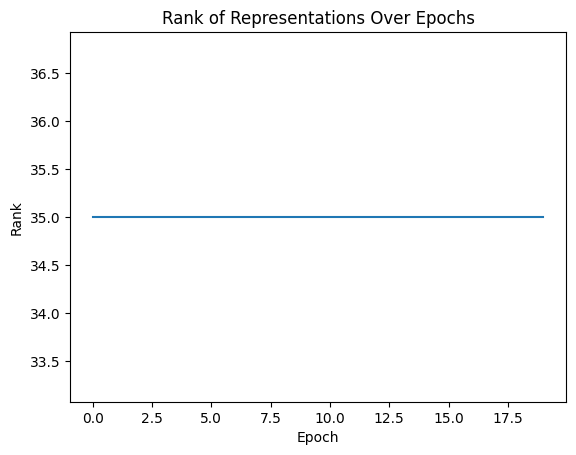

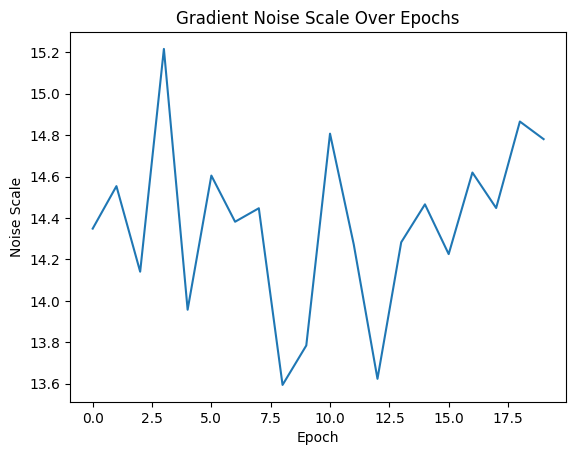

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import logging
from scipy.stats import linregress

# Set up logging
logging.basicConfig(
    filename="training.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="w"
)
logger = logging.getLogger()

# Set device to MPS (Apple Metal Performance Shaders)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define dataset loader with optional train/test size limits
def load_dataset(dataset_name="MNIST", batch_size=32, train_size=None, test_size=None):
    logger.info(f"Loading {dataset_name} dataset with batch size {batch_size}, train_size={train_size}, test_size={test_size}")

    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        full_train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    else:
        logger.error("Unsupported dataset. Only 'MNIST' is supported.")
        raise ValueError("Unsupported dataset. Currently only 'MNIST' is supported.")

    train_dataset = full_train_dataset if train_size is None else Subset(full_train_dataset, range(train_size))
    test_dataset = full_test_dataset if test_size is None else Subset(full_test_dataset, range(test_size))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    logger.info("Dataset successfully loaded.")
    return train_loader, test_loader

# Define a simple fully connected neural network
class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

# Function to compute alignment metrics
def compute_alignment(matrix1, matrix2):
    norm1 = torch.norm(matrix1, p='fro')
    norm2 = torch.norm(matrix2, p='fro')
    alignment = torch.trace(matrix1 @ matrix2.T) / (norm1 * norm2)
    logger.info(f"Computed alignment: {alignment.item():.6f}")
    return alignment.item()

# Function to compute power-law exponents
def compute_power_law_exponent(eigenvalues):
    indices = np.arange(1, len(eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))
    logger.info(f"Computed power-law exponent: {slope:.6f}")
    return slope

# Training loop with logging
def train_and_log_metrics(model, dataloader, optimizer, criterion, num_epochs=10):
    logger.info(f"Starting training for {num_epochs} epochs")

    model.to(device)  # Move model to MPS
    alignments = []
    eigenvalue_spectra = []
    rank_history = []
    gradient_noise_scales = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move data to MPS

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

        # Compute metrics
        with torch.no_grad():
            weights = model.model[0].weight
            gradients = model.model[0].weight.grad

            # Ensure covariance matrices remain on CPU if necessary
            X_cpu = X.view(X.size(0), -1).cpu()
            gradients_cpu = gradients.cpu()

            covariance_h = torch.cov(X_cpu.T)
            covariance_g = torch.cov(gradients_cpu.T)

            alignment = compute_alignment(covariance_h, covariance_g)
            alignments.append(alignment)

            eigenvalues_h = torch.linalg.eigvalsh(covariance_h).cpu().numpy()
            eigenvalue_spectra.append(eigenvalues_h)

            rank = torch.linalg.matrix_rank(covariance_h).item()
            rank_history.append(rank)
            logger.info(f"Epoch [{epoch+1}/{num_epochs}], Rank: {rank}")

            grad_norm = torch.norm(gradients)
            noise_scale = grad_norm / (torch.norm(gradients, dim=1).mean())
            gradient_noise_scales.append(noise_scale.item())
            logger.info(f"Epoch [{epoch+1}/{num_epochs}], Gradient Noise Scale: {noise_scale.item():.6f}")

    logger.info("Training completed successfully.")
    return alignments, eigenvalue_spectra, rank_history, gradient_noise_scales

# Visualization functions
def plot_alignment(alignments):
    plt.plot(alignments)
    plt.title("Alignment Metrics Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Alignment")
    plt.show()

def plot_eigenvalues(eigenvalue_spectra):
    for epoch, eigvals in enumerate(eigenvalue_spectra):
        if epoch % 10 == 0:
            plt.plot(eigvals, label=f"Epoch {epoch}")
    plt.title("Eigenvalue Spectra Over Epochs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.show()

def plot_rank_history(rank_history):
    plt.plot(rank_history)
    plt.title("Rank of Representations Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Rank")
    plt.show()

def plot_gradient_noise_scales(gradient_noise_scales):
    plt.plot(gradient_noise_scales)
    plt.title("Gradient Noise Scale Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Noise Scale")
    plt.show()

# Main script
if __name__ == "__main__":
    try:
        # Parameters
        input_dim = 28 * 28  # For MNIST
        hidden_dim = 128
        output_dim = 10
        batch_size = 64
        learning_rate = 0.01
        num_epochs = 20

        # Load dataset and model
        train_loader, test_loader = load_dataset("MNIST", batch_size=batch_size, train_size=100, test_size=20)

        model = FullyConnectedNet(input_dim, hidden_dim, output_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Train and log metrics
        alignments, eigenvalue_spectra, rank_history, gradient_noise_scales = train_and_log_metrics(
            model, train_loader, optimizer, criterion, num_epochs
        )

        # Plot results
        plot_alignment(alignments)
        plot_eigenvalues(eigenvalue_spectra)
        plot_rank_history(rank_history)
        plot_gradient_noise_scales(gradient_noise_scales)

    except Exception as e:
        logger.critical(f"Fatal error in training: {str(e)}", exc_info=True)


Files already downloaded and verified
Files already downloaded and verified


/var/folders/6p/x54f4_t51z75lb262gn_9w940000gn/T/ipykernel_55379/776276873.py:104: RuntimeWarning: invalid value encountered in log
  slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))


Final Alignment Metric: 1.8062744723787736e-08
Final Rank Deficiency: 3
Final Gradient Noise Scale: 5.210635185241699
Final Power-Law Exponent: nan


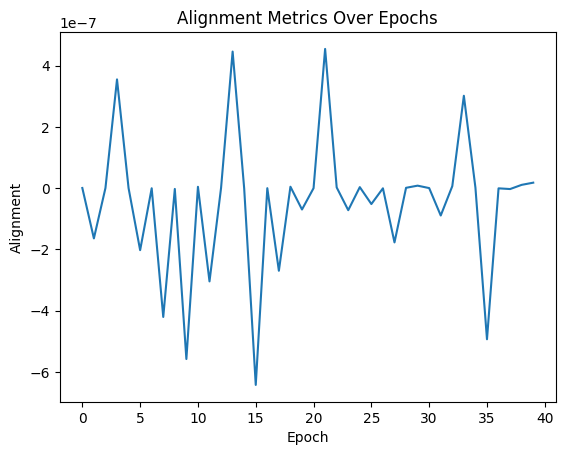

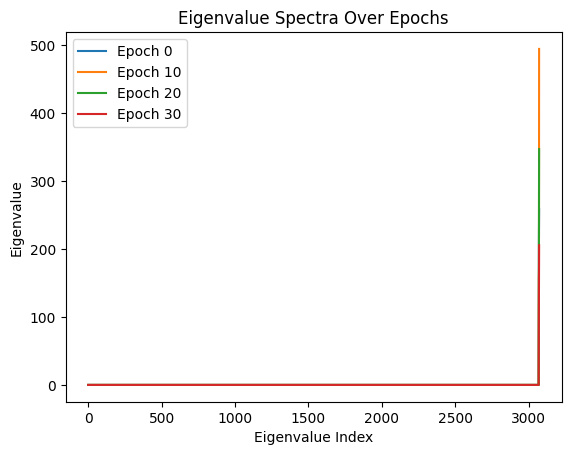

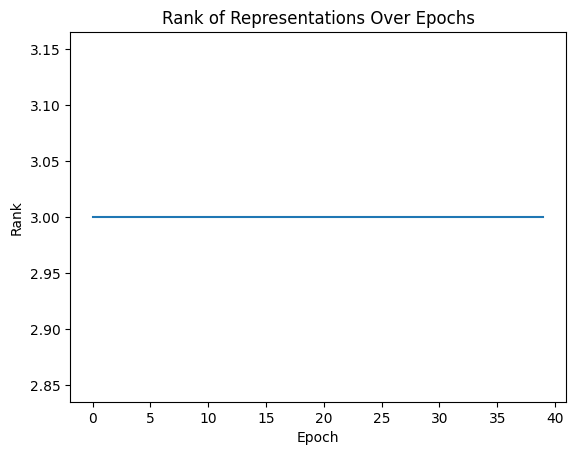

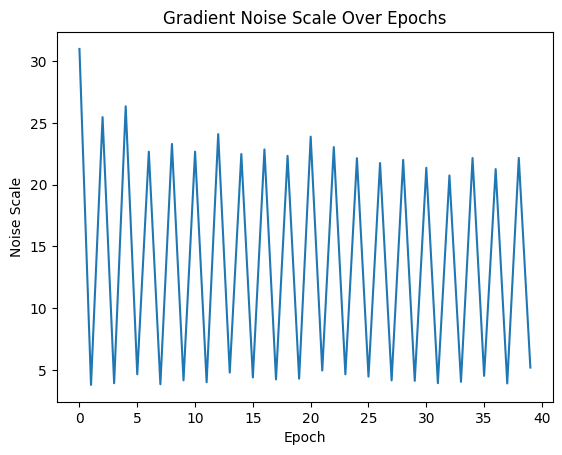

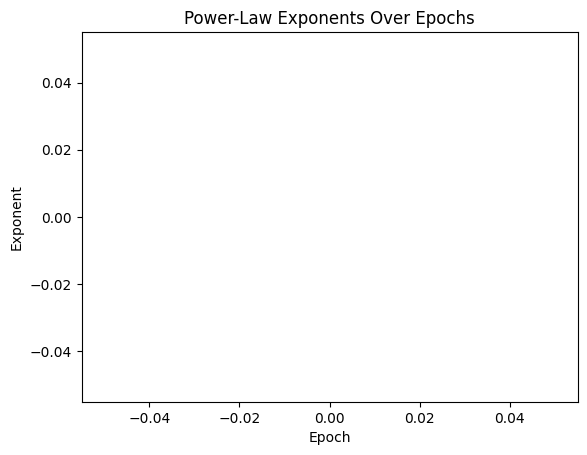

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Check for MPS (Metal Performance Shaders) backend
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define dataset loader with optional train/test size parameters
def load_dataset(dataset_name="MNIST", batch_size=32, train_size=None, test_size=None):
    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        full_train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        full_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Currently supported: 'MNIST', 'CIFAR10'.")

    # Subset the datasets if sizes are specified
    if train_size is not None and train_size < len(full_train_dataset):
        train_dataset = torch.utils.data.Subset(full_train_dataset, range(train_size))
    else:
        train_dataset = full_train_dataset

    if test_size is not None and test_size < len(full_test_dataset):
        test_dataset = torch.utils.data.Subset(full_test_dataset, range(test_size))
    else:
        test_dataset = full_test_dataset

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Define a simple fully connected neural network
class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.model(x.view(x.size(0), -1))
    

# Define a ResNet-like CNN
class SimpleResNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Corrected input size
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.avg_pool2d(x, 2)  # Output shape: (batch_size, 128, 16, 16)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Compute alignment metrics (Pearson Correlation)
def compute_alignment(matrix1, matrix2):
    d = matrix1.shape[0]
    sum_product = torch.sum(matrix1 * matrix2)
    sum_matrix1 = torch.sum(matrix1)
    sum_matrix2 = torch.sum(matrix2)
    pearson_corr = (sum_product / (d**2)) - ((sum_matrix1 * sum_matrix2) / (d**4))
    normalization_factor = torch.norm(matrix1, p='fro') * torch.norm(matrix2, p='fro')
    return pearson_corr.item() / normalization_factor.item()

# Compute power-law exponents
def compute_power_law_exponent(eigenvalues):
    indices = np.arange(1, len(eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))
    return slope

# Compute rank deficiency
def compute_rank_deficiency(matrix):
    return torch.linalg.matrix_rank(matrix).item()

# Compute gradient noise scale
def compute_gradient_noise_scale(gradients):
    grad_norm = torch.norm(gradients)
    mean_grad_norm = torch.norm(gradients, dim=1).mean()
    return (grad_norm / mean_grad_norm).item()

# Train and log metrics
def train_and_log_metrics(model, dataloader, optimizer, criterion, num_epochs=10):
    alignments = []
    eigenvalue_spectra = []
    rank_history = []
    gradient_noise_scales = []
    power_law_exponents = []
    
    for epoch in range(num_epochs):
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        
        logging.info(f"Loss after epoch {epoch+1}: {loss.item()}")
        
        # Compute alignment metrics and eigenvalue spectra
        with torch.no_grad():
            for layer in model.children():
                if isinstance(layer, nn.Linear):
                    weights = layer.weight
                    gradients = layer.weight.grad
                    
                    # Flatten input data for covariance computation
                    flattened_X = X.view(X.size(0), -1)
                    
                    # Compute covariance of input data on CPU
                    covariance_h = torch.cov(flattened_X.cpu().T)
                    
                    # Flatten gradients consistently
                    flattened_gradients = gradients.view(gradients.size(0), -1)
                    
                    # Compute gradient covariance on CPU
                    covariance_g = torch.cov(flattened_gradients.cpu().T)
                    
                    # Ensure matrices have same dimensions for alignment
                    min_dim = min(covariance_h.size(0), covariance_g.size(0))
                    covariance_h = covariance_h[:min_dim, :min_dim]
                    covariance_g = covariance_g[:min_dim, :min_dim]
                    
                    # Compute alignment
                    alignment = compute_alignment(covariance_h, covariance_g)
                    alignments.append(alignment)
                    
                    # Compute eigenvalues and other metrics on CPU
                    eigenvalues_h = torch.linalg.eigvalsh(covariance_h).numpy()
                    eigenvalue_spectra.append(eigenvalues_h)
                    rank = compute_rank_deficiency(covariance_h)
                    rank_history.append(rank)
                    
                    # Power-law exponent
                    exponent = compute_power_law_exponent(eigenvalues_h)
                    power_law_exponents.append(exponent)
                    
                    # Gradient noise scale
                    noise_scale = compute_gradient_noise_scale(gradients)
                    gradient_noise_scales.append(noise_scale)
    
    return alignments, eigenvalue_spectra, rank_history, gradient_noise_scales, power_law_exponents

# Visualization functions
def plot_alignment(alignments):
    plt.plot(alignments)
    plt.title("Alignment Metrics Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Alignment")
    plt.show()

def plot_eigenvalues(eigenvalue_spectra):
    for epoch, eigvals in enumerate(eigenvalue_spectra):
        if epoch % 10 == 0:
            plt.plot(eigvals, label=f"Epoch {epoch}")
    plt.title("Eigenvalue Spectra Over Epochs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.show()

def plot_rank_history(rank_history):
    plt.plot(rank_history)
    plt.title("Rank of Representations Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Rank")
    plt.show()

def plot_gradient_noise_scales(gradient_noise_scales):
    plt.plot(gradient_noise_scales)
    plt.title("Gradient Noise Scale Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Noise Scale")
    plt.show()

def plot_power_law_exponents(power_law_exponents):
    plt.plot(power_law_exponents)
    plt.title("Power-Law Exponents Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Exponent")
    plt.show()

# Main script
if __name__ == "__main__":
    # Parameters
    dataset_name = "CIFAR10"  # Switch between "MNIST" and "CIFAR10"
    input_dim = 28 * 28 if dataset_name == "MNIST" else None
    hidden_dim = 128
    output_dim = 10
    batch_size = 8
    train_size = 100
    test_size = 20
    learning_rate = 0.01
    num_epochs = 20
    
    # Load dataset and model
    train_loader, test_loader = load_dataset(dataset_name, batch_size=batch_size, train_size=train_size, test_size=test_size)
    if dataset_name == "MNIST":
        model = FullyConnectedNet(input_dim, hidden_dim, output_dim).to(device)
    elif dataset_name == "CIFAR10":
        model = SimpleResNet(input_channels=3, num_classes=output_dim).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Train and log metrics
    alignments, eigenvalue_spectra, rank_history, gradient_noise_scales, power_law_exponents = train_and_log_metrics(
        model, train_loader, optimizer, criterion, num_epochs
    )
    
    # Print metrics
    print("Final Alignment Metric:", alignments[-1])
    print("Final Rank Deficiency:", rank_history[-1])
    print("Final Gradient Noise Scale:", gradient_noise_scales[-1])
    print("Final Power-Law Exponent:", power_law_exponents[-1])
    
    # Plot results
    plot_alignment(alignments)
    plot_eigenvalues(eigenvalue_spectra)
    plot_rank_history(rank_history)
    plot_gradient_noise_scales(gradient_noise_scales)
    plot_power_law_exponents(power_law_exponents)

## EIGEN VALUES: Filter out zero or negative eigenvalues

Files already downloaded and verified
Files already downloaded and verified
Final Alignment Metric: 1.8062744723787736e-08
Final Rank Deficiency: 3
Final Gradient Noise Scale: 5.210635185241699
Final Power-Law Exponent: 1.615087999641539


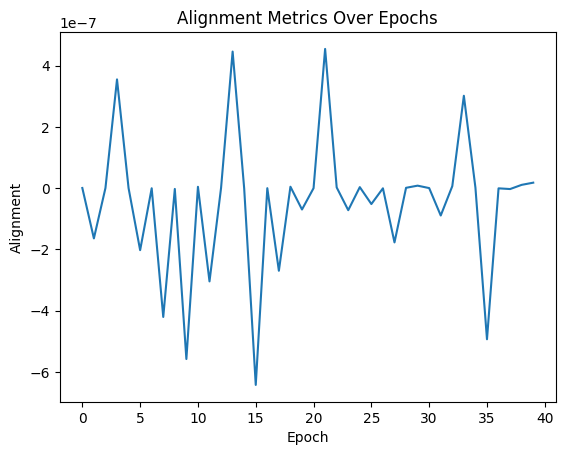

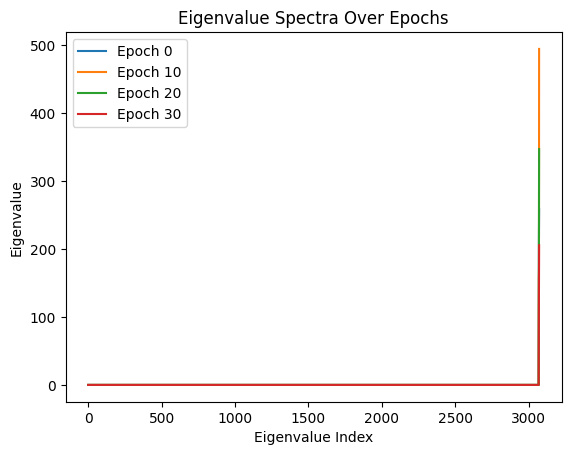

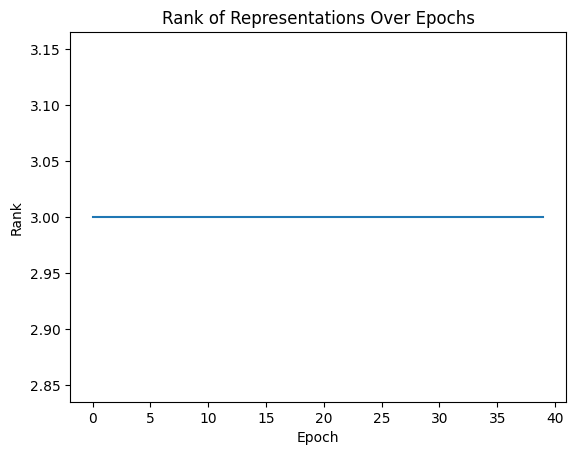

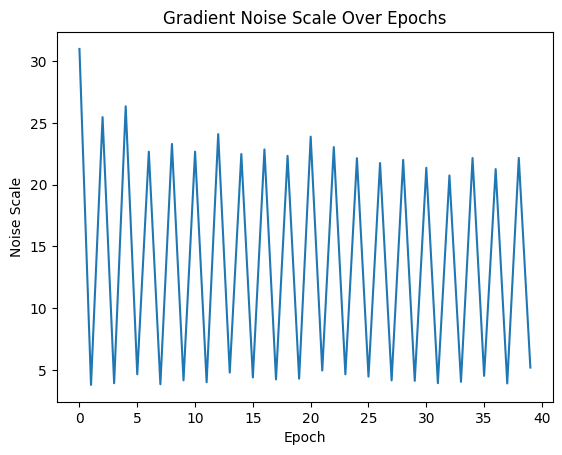

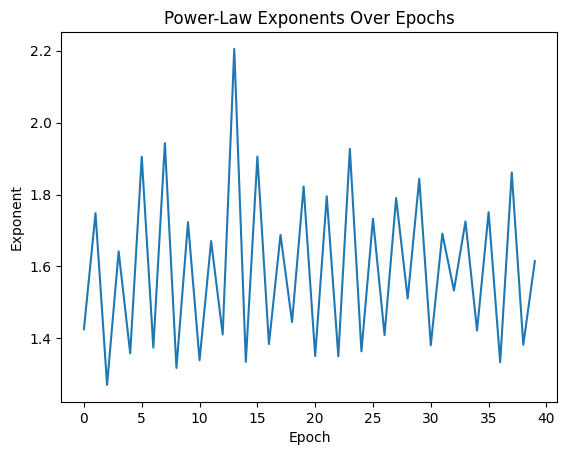

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Check for MPS (Metal Performance Shaders) backend
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define dataset loader with optional train/test size parameters
def load_dataset(dataset_name="MNIST", batch_size=32, train_size=None, test_size=None):
    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        full_train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        full_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Currently supported: 'MNIST', 'CIFAR10'.")

    # Subset the datasets if sizes are specified
    if train_size is not None and train_size < len(full_train_dataset):
        train_dataset = torch.utils.data.Subset(full_train_dataset, range(train_size))
    else:
        train_dataset = full_train_dataset

    if test_size is not None and test_size < len(full_test_dataset):
        test_dataset = torch.utils.data.Subset(full_test_dataset, range(test_size))
    else:
        test_dataset = full_test_dataset

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Define a simple fully connected neural network
class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.model(x.view(x.size(0), -1))
    

# Define a ResNet-like CNN
class SimpleResNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Corrected input size
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.avg_pool2d(x, 2)  # Output shape: (batch_size, 128, 16, 16)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Compute alignment metrics (Pearson Correlation)
def compute_alignment(matrix1, matrix2):
    d = matrix1.shape[0]
    sum_product = torch.sum(matrix1 * matrix2)
    sum_matrix1 = torch.sum(matrix1)
    sum_matrix2 = torch.sum(matrix2)
    pearson_corr = (sum_product / (d**2)) - ((sum_matrix1 * sum_matrix2) / (d**4))
    normalization_factor = torch.norm(matrix1, p='fro') * torch.norm(matrix2, p='fro')
    return pearson_corr.item() / normalization_factor.item()

# Compute power-law exponents
def compute_power_law_exponent(eigenvalues):
    # Filter out zero or negative eigenvalues
    valid_eigenvalues = eigenvalues[eigenvalues > 0]
    if len(valid_eigenvalues) < 2:
        return float('nan')  # Not enough valid eigenvalues for regression
    
    indices = np.arange(1, len(valid_eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), np.log(valid_eigenvalues))
    return slope

# Compute rank deficiency
def compute_rank_deficiency(matrix):
    return torch.linalg.matrix_rank(matrix).item()

# Compute gradient noise scale
def compute_gradient_noise_scale(gradients):
    grad_norm = torch.norm(gradients)
    mean_grad_norm = torch.norm(gradients, dim=1).mean()
    return (grad_norm / mean_grad_norm).item()

# Train and log metrics
def train_and_log_metrics(model, dataloader, optimizer, criterion, num_epochs=10):
    alignments = []
    eigenvalue_spectra = []
    rank_history = []
    gradient_noise_scales = []
    power_law_exponents = []
    
    for epoch in range(num_epochs):
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        
        logging.info(f"Loss after epoch {epoch+1}: {loss.item()}")
        
        # Compute alignment metrics and eigenvalue spectra
        with torch.no_grad():
            for layer in model.children():
                if isinstance(layer, nn.Linear):
                    weights = layer.weight
                    gradients = layer.weight.grad
                    
                    # Flatten input data for covariance computation
                    flattened_X = X.view(X.size(0), -1)
                    
                    # Compute covariance of input data on CPU
                    covariance_h = torch.cov(flattened_X.cpu().T)
                    
                    # Flatten gradients consistently
                    flattened_gradients = gradients.view(gradients.size(0), -1)
                    
                    # Compute gradient covariance on CPU
                    covariance_g = torch.cov(flattened_gradients.cpu().T)
                    
                    # Ensure matrices have same dimensions for alignment
                    min_dim = min(covariance_h.size(0), covariance_g.size(0))
                    covariance_h = covariance_h[:min_dim, :min_dim]
                    covariance_g = covariance_g[:min_dim, :min_dim]
                    
                    # Compute alignment
                    alignment = compute_alignment(covariance_h, covariance_g)
                    alignments.append(alignment)
                    
                    # Compute eigenvalues and other metrics on CPU
                    eigenvalues_h = torch.linalg.eigvalsh(covariance_h).numpy()
                    eigenvalue_spectra.append(eigenvalues_h)
                    rank = compute_rank_deficiency(covariance_h)
                    rank_history.append(rank)
                    
                    # Power-law exponent
                    exponent = compute_power_law_exponent(eigenvalues_h)
                    power_law_exponents.append(exponent)
                    
                    # Gradient noise scale
                    noise_scale = compute_gradient_noise_scale(gradients)
                    gradient_noise_scales.append(noise_scale)
    
    return alignments, eigenvalue_spectra, rank_history, gradient_noise_scales, power_law_exponents

# Visualization functions
def plot_alignment(alignments):
    plt.plot(alignments)
    plt.title("Alignment Metrics Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Alignment")
    plt.show()

def plot_eigenvalues(eigenvalue_spectra):
    for epoch, eigvals in enumerate(eigenvalue_spectra):
        if epoch % 10 == 0:
            plt.plot(eigvals, label=f"Epoch {epoch}")
    plt.title("Eigenvalue Spectra Over Epochs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.show()

def plot_rank_history(rank_history):
    plt.plot(rank_history)
    plt.title("Rank of Representations Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Rank")
    plt.show()

def plot_gradient_noise_scales(gradient_noise_scales):
    plt.plot(gradient_noise_scales)
    plt.title("Gradient Noise Scale Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Noise Scale")
    plt.show()

def plot_power_law_exponents(power_law_exponents):
    plt.plot(power_law_exponents)
    plt.title("Power-Law Exponents Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Exponent")
    plt.show()

# Main script
if __name__ == "__main__":
    # Parameters
    dataset_name = "CIFAR10"  # Switch between "MNIST" and "CIFAR10"
    input_dim = 28 * 28 if dataset_name == "MNIST" else None
    hidden_dim = 128
    output_dim = 10
    batch_size = 8
    train_size = 100
    test_size = 20
    learning_rate = 0.01
    num_epochs = 20
    
    # Load dataset and model
    train_loader, test_loader = load_dataset(dataset_name, batch_size=batch_size, train_size=train_size, test_size=test_size)
    if dataset_name == "MNIST":
        model = FullyConnectedNet(input_dim, hidden_dim, output_dim).to(device)
    elif dataset_name == "CIFAR10":
        model = SimpleResNet(input_channels=3, num_classes=output_dim).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Train and log metrics
    alignments, eigenvalue_spectra, rank_history, gradient_noise_scales, power_law_exponents = train_and_log_metrics(
        model, train_loader, optimizer, criterion, num_epochs
    )
    
    # Print metrics
    print("Final Alignment Metric:", alignments[-1])
    print("Final Rank Deficiency:", rank_history[-1])
    print("Final Gradient Noise Scale:", gradient_noise_scales[-1])
    print("Final Power-Law Exponent:", power_law_exponents[-1])
    
    # Plot results
    plot_alignment(alignments)
    plot_eigenvalues(eigenvalue_spectra)
    plot_rank_history(rank_history)
    plot_gradient_noise_scales(gradient_noise_scales)
    plot_power_law_exponents(power_law_exponents)

Files already downloaded and verified
Files already downloaded and verified


/var/folders/6p/x54f4_t51z75lb262gn_9w940000gn/T/ipykernel_55379/509434984.py:83: RuntimeWarning: invalid value encountered in log
  slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))


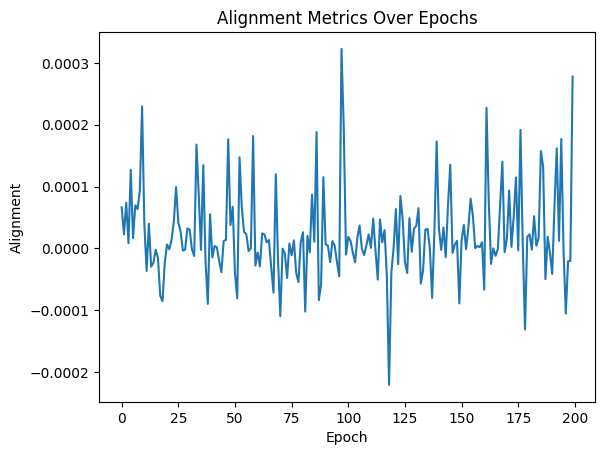

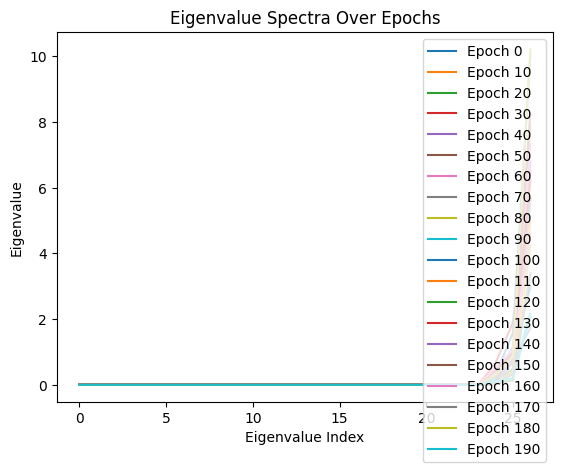

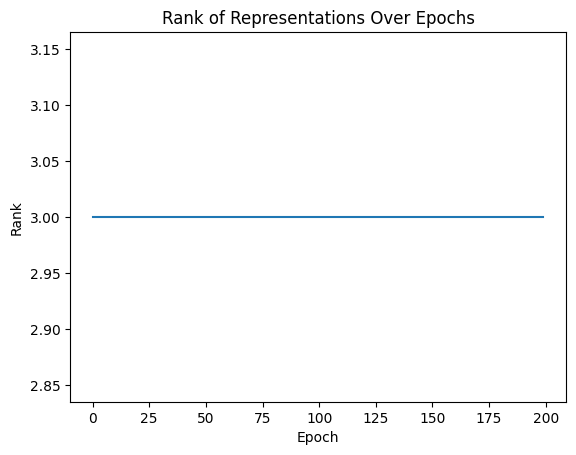

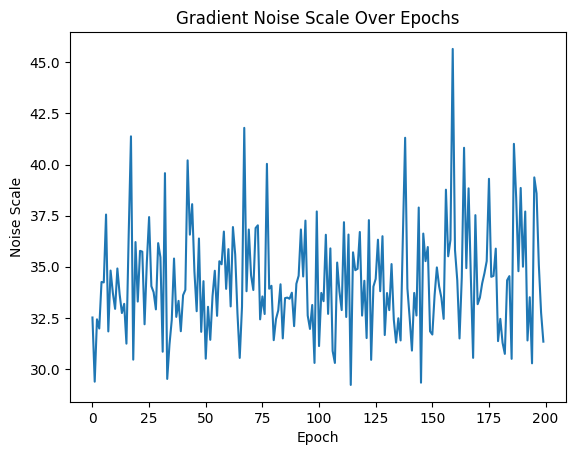

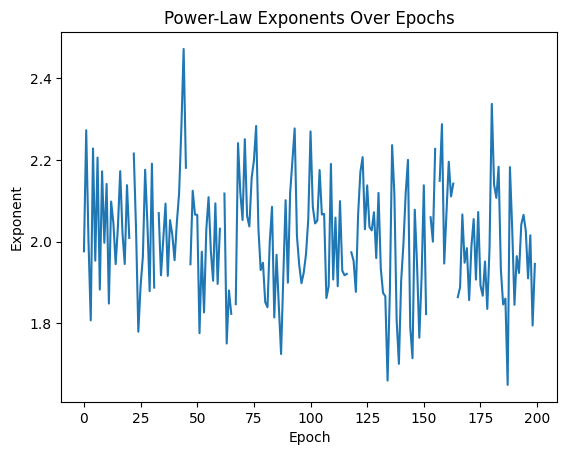

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Check for MPS (Metal Performance Shaders) backend
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define dataset loader with optional train/test size parameters
def load_dataset(dataset_name="MNIST", batch_size=8, train_size=100, test_size=20):
    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        full_train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        full_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
        full_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Currently supported: 'MNIST', 'CIFAR10'.")

    # Subset the datasets if sizes are specified
    if train_size is not None and train_size < len(full_train_dataset):
        train_dataset = torch.utils.data.Subset(full_train_dataset, range(train_size))
    else:
        train_dataset = full_train_dataset

    if test_size is not None and test_size < len(full_test_dataset):
        test_dataset = torch.utils.data.Subset(full_test_dataset, range(test_size))
    else:
        test_dataset = full_test_dataset

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Define a simple fully connected neural network
class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

# Compute alignment metrics (Pearson Correlation)
def compute_alignment(matrix1, matrix2):
    d = matrix1.shape[0]
    sum_product = torch.sum(matrix1 * matrix2)
    sum_matrix1 = torch.sum(matrix1)
    sum_matrix2 = torch.sum(matrix2)
    pearson_corr = (sum_product / (d**2)) - ((sum_matrix1 * sum_matrix2) / (d**4))
    normalization_factor = torch.norm(matrix1, p='fro') * torch.norm(matrix2, p='fro')
    return pearson_corr.item() / normalization_factor.item()

# Compute power-law exponents
def compute_power_law_exponent(eigenvalues):
    indices = np.arange(1, len(eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))
    return slope

# Regularize covariance matrices
def regularize_covariance(matrix, epsilon=1e-6):
    identity = torch.eye(matrix.shape[0], device=matrix.device)
    return matrix + epsilon * identity

# Training loop with advanced metrics logging
def train_and_log_metrics(model, dataloader, optimizer, criterion, num_epochs=10):
    alignments = []
    eigenvalue_spectra = []
    rank_history = []
    gradient_noise_scales = []
    power_law_exponents = []
    
    for epoch in range(num_epochs):
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        
        # Compute alignment metrics and eigenvalue spectra
        with torch.no_grad():
            # Dynamically access the first layer's weight
            first_layer = next(model.children())
            weights = first_layer.weight
            gradients = first_layer.weight.grad
            
            # Flatten input data for covariance computation
            flattened_X = X.view(X.size(0), -1)
            
            # Compute covariance of input data on CPU
            covariance_h = torch.cov(flattened_X.cpu().T)
            covariance_h = regularize_covariance(covariance_h)
            
            # Flatten gradients consistently
            flattened_gradients = gradients.view(gradients.size(0), -1)
            
            # Compute gradient covariance on CPU
            covariance_g = torch.cov(flattened_gradients.cpu().T)
            #covariance_g = regularize_covariance(covariance_g)
            
            # Ensure matrices have same dimensions for alignment
            min_dim = min(covariance_h.size(0), covariance_g.size(0))
            covariance_h = covariance_h[:min_dim, :min_dim]
            covariance_g = covariance_g[:min_dim, :min_dim]
            
            # Compute alignment
            alignment = compute_alignment(covariance_h, covariance_g)
            alignments.append(alignment)
            
            # Compute eigenvalues and other metrics on CPU
            eigenvalues_h = torch.linalg.eigvalsh(covariance_h).cpu().numpy()
            eigenvalue_spectra.append(eigenvalues_h)
            rank = torch.linalg.matrix_rank(covariance_h).item()
            rank_history.append(rank)
            
            # Power-law exponent
            exponent = compute_power_law_exponent(eigenvalues_h)
            power_law_exponents.append(exponent)
            
            # Gradient noise scale
            grad_norm = torch.norm(gradients)
            noise_scale = grad_norm / (torch.norm(gradients, dim=1).mean())
            gradient_noise_scales.append(noise_scale.item())
    
    return alignments, eigenvalue_spectra, rank_history, gradient_noise_scales, power_law_exponents

# Visualization functions
def plot_alignment(alignments):
    plt.plot(alignments)
    plt.title("Alignment Metrics Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Alignment")
    plt.show()

def plot_eigenvalues(eigenvalue_spectra):
    for epoch, eigvals in enumerate(eigenvalue_spectra):
        if epoch % 10 == 0:
            plt.plot(eigvals, label=f"Epoch {epoch}")
    plt.title("Eigenvalue Spectra Over Epochs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.show()

def plot_rank_history(rank_history):
    plt.plot(rank_history)
    plt.title("Rank of Representations Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Rank")
    plt.show()

def plot_gradient_noise_scales(gradient_noise_scales):
    plt.plot(gradient_noise_scales)
    plt.title("Gradient Noise Scale Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Noise Scale")
    plt.show()

def plot_power_law_exponents(power_law_exponents):
    plt.plot(power_law_exponents)
    plt.title("Power-Law Exponents Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Exponent")
    plt.show()

# Main script
if __name__ == "__main__":
    # Parameters
    dataset_name = "CIFAR10"
    input_dim = 28 * 28 if dataset_name == "MNIST" else None
    hidden_dim = 128
    output_dim = 10
    batch_size = 8
    learning_rate = 0.01
    num_epochs = 200
    train_size = 100
    test_size = 20
    
    # Load dataset and model
    train_loader, test_loader = load_dataset(dataset_name=dataset_name, batch_size=batch_size, test_size=test_size, train_size=train_size)

    model = None

    if dataset_name == "MNIST":
        model = FullyConnectedNet(input_dim, hidden_dim, output_dim).to(device)
    elif dataset_name == "CIFAR10":
        model = SimpleResNet(input_channels=3, num_classes=output_dim).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Train and log metrics
    alignments, eigenvalue_spectra, rank_history, gradient_noise_scales, power_law_exponents = train_and_log_metrics(
        model, train_loader, optimizer, criterion, num_epochs
    )
    
    # Plot results
    plot_alignment(alignments)
    plot_eigenvalues(eigenvalue_spectra)
    plot_rank_history(rank_history)
    plot_gradient_noise_scales(gradient_noise_scales)
    plot_power_law_exponents(power_law_exponents)